In [ ]:
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium import spaces

import math
import random, datetime, os, time
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from collections import deque, defaultdict, namedtuple
from itertools import count
from enum import Enum
import torch.utils.data as data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T

from tensordict.tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage
import torchrl.data as tcd

from pyboy import PyBoy

import logging


In [28]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [29]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [30]:
class Actions(Enum):
    NOOP = 0
    LEFT = 1
    RIGHT = 2
    UP = 3
    DOWN = 4
    B = 5
    A = 6
    LONG_JUMP = 7

In [31]:
class MarioEnv(gym.Env):
    def __init__(self, pyboy, debug=False):
        super().__init__()
        self.pyboy = pyboy
        self.debug = debug
        
        self._fitness=0
        self._previous_fitness=0
        
        self.debug = debug

        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=0, high=255, shape=(16, 20), dtype=np.uint16)
        self.pyboy.game_wrapper.start_game()
   
    
    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))

        # Move the agent
        if action == Actions.NOOP.value:
            pass
        elif action == Actions.LEFT.value:
            self.pyboy.button_press("left")
        elif action == Actions.RIGHT.value:
            self.pyboy.button_press("right")
        elif action == Actions.UP.value:
            self.pyboy.button("up")
        elif action == Actions.DOWN.value:
            self.pyboy.button("down")
        elif action == Actions.B.value:
            self.pyboy.button_press("b")
            self.pyboy.button_release("b")
        elif action == Actions.A.value:
            self.pyboy.button_press("a")
        elif action == Actions.LONG_JUMP.value:
            self.pyboy.button_press("b")
            self.pyboy.button_press("right")
            self.pyboy.button("a")

        self.pyboy.tick()
        
        # done change to terminated
        terminated = self.pyboy.game_wrapper.game_over
        
        self._calculate_fitness()
        reward = self._fitness-self._previous_fitness
        
        observation=self._get_obs()
        info = self.pyboy.game_wrapper
        truncated = False

        return observation, reward, terminated, truncated, info
    
    def _calculate_fitness(self):
        self._previous_fitness=self._fitness

        # NOTE: Only some game wrappers will provide a score
        # If not, you'll have to investigate how to score the game yourself
        self._fitness=self.pyboy.game_wrapper.score
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._fitness=0
        self._previous_fitness=0
            
        observation=self._get_obs()
        info = {}
        return observation, info

    def render(self):
        self.pyboy.tick()

    def close(self):
        self.pyboy.stop()

    def _get_obs(self):
        self.pyboy.game_wrapper.game_area_mapping(self.pyboy.game_wrapper.mapping_compressed, 0)
        return self.pyboy.game_area()

In [32]:
from gymnasium.wrappers import FlattenObservation

pyboy = PyBoy("rom.gb", window="null")
env = MarioEnv(pyboy)
env = FlattenObservation(env)

In [33]:
mario = pyboy.game_wrapper

In [34]:
env.observation_space

Box(0, 255, (320,), uint16)

In [35]:
observation, info = env.reset()
observation

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [36]:
n_observations = len(torch.tensor((observation)))
n_observations

320

In [37]:
n_actions = env.action_space.n
n_actions

8

In [48]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [39]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [49]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [50]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

In [51]:
policy_net

DQN(
  (layer1): Linear(in_features=320, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=8, bias=True)
)

In [52]:
target_net

DQN(
  (layer1): Linear(in_features=320, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=8, bias=True)
)

In [61]:
steps_done = 0
state = torch.tensor((observation), device=device, dtype=torch.float32).unsqueeze(0)


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    
select_action(state)

tensor([[5]], device='cuda:0')

In [45]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [46]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = [s for s in batch.next_state if s is not None]

    if non_final_next_states:
        non_final_next_states = torch.cat(non_final_next_states)
    else:
        non_final_next_states = None

    state_batch = torch.cat([s.clone().detach() for s in batch.state])
    action_batch = torch.cat([a.clone().detach() for a in batch.action])
    reward_batch = torch.cat([r.clone().detach() for r in batch.reward])

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    if non_final_next_states is not None:
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Complete


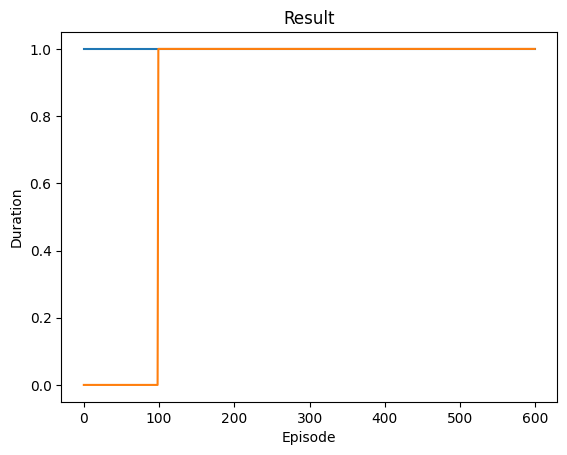

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [47]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

assert mario.lives_left == 2

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if mario.lives_left < 2:
            mario.reset_game()

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()